In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

# Select predictions file

In [2]:
ppaths = os.listdir('preds')
for i in range(len(ppaths)):
    if 'pred' in ppaths[i]:
        print(i, ':', ppaths[i])

0 : predictions_FRAME.npy
1 : predictions_inception_original_missingvids_minorimbalance_5epochs_213609_03-13.npy
2 : predictions_resnet_original_missingvids_minorimbalance_15epochs_153620_03-14.npy
3 : predictions_0.15s_missingvids_minorimbalance_5epochs_152927_03-05.npy
4 : predictions_inception_original_missingvids_minorimbalance_5epochs_64bs_153620_03-14.npy
5 : predictions_ominus1s_missingvids_minorimbalance_5epochs_184859_03-04.npy
6 : predictions_small0.15s_missingvids_minorimbalance_5epochs_121526_03-09.npy
7 : predictions_FRAME_all.npy
8 : predictions_small1s_missingvids_minorimbalance_5epochs_120943_03-06.npy
9 : predictions_s2_missingvids_minorimbalance_5epochs_181615_03-01.npy
10 : predictions_vgg_original_missingvids_minorimbalance_5epochs_215612_03-13.npy
11 : predictions_densenet_original_missingvids_minorimbalance_5epochs_103622_03-15.npy
12 : predictions_o_missingvids_minorimbalance_5epochs_224638_02-20.npy
13 : predictions_resnet_original_missingvids_minorimbalance_5ep

In [3]:
#selection = [5, 1, 4, 7, 9, 6, 0, 3, 2] # manually choose here or clean the preds dir manually of bad preds
#titles = ['original', 'original (reduced)', '2s', '1s', '500ms', '333ms', '150ms', '1s (10 FIs)', '150ms (60 FIs)']

selection = [12]
titles = ['original']
paths = ['./preds/'+ppaths[i] for i in selection]
paths

['./preds/predictions_o_missingvids_minorimbalance_5epochs_224638_02-20.npy']

# Process video level predictions

In [4]:
def getyp(preds, optimal_thresh):
    # this is a dictionary that stores predictions
    # key = video name
    # value = [count of filtered images above threshold, count of filtered images per video, true label of 0 or 1 (normal or nystagmus)]
    vids_dict = dict()
    for pred in preds:
        name = pred[0].split('/')[1].split('.')[0]
        name = name.split('-')[0] + name.split('-')[1]
        prob = float(pred[2])
        try:
            p, c, label = vids_dict[name]
            # p += prob
            p += 1 if prob >= optimal_thresh else 0
            c += 1
            vids_dict[name] = (p, c, label)
        except:
            # p = prob
            p = 1 if prob >= optimal_thresh else 0
            c = 1
            label = int(float('nystagmus' in pred[0]))
            vids_dict[name] = (p,c,label)
    # this function calculates a list of probabilities of nystagmus for each video
    # vid_dict.keys(), y, probs are in same order (print to view)

    y = []
    probs = []
    for key in vids_dict.keys():
        p, c, label = vids_dict[key]
        y.append(label)
        prob = float(p)/float(c)
        probs.append(prob)
    y = np.array(y) # true labels
    probs = np.array(probs) # predicted probabilities of nystagmus
    return y, probs

# Process predictions

In [5]:
def manual_correction(preds):
    cases = ['04-GazeC_V', '10-lean', '18-GazeR_V']
    corrected_preds = []
    for pred in preds:
        cpred = pred
        for case in cases:
            if case in cpred[0]:
                cpred[0] = 'nystagmus' + '/' + cpred[0].split('/')[1]
        corrected_preds.append(cpred)
    corrected_preds = np.array(corrected_preds)
    return corrected_preds

In [12]:
def process_preds(path, window=0):
    name = path.split('_')[1]
    
    preds = np.load(path)
    
    preds = manual_correction(preds)
    
    if window > 0:
        wtf = int(window*60.0)
        preds_new = []
        for pred in preds:
            finum = int(pred[0].split('-')[2].split('.')[0])
            if finum < wtf:
                preds_new.append(pred)
        preds = np.array(preds_new)
    
    probs_fi = np.array([float(p) for p in preds[:, 2]])
    y_fi = np.array([int(float('nystagmus' in l)) for l in preds[:,0]])
    fpr, tpr, thresh = roc_curve(y_fi, probs_fi, pos_label=1)
    auc_score = roc_auc_score(y_fi, probs_fi)
    # print(name + ' AUC = ', auc_score)
    
    optimal_thresh = thresh[np.argmax(tpr-fpr)]
    print(name + ' Optimal Threshold for FI probs = ',round(optimal_thresh*100,2),'%')
    
    y, probs = getyp(preds, optimal_thresh)
    
    fpr, tpr, thresh = roc_curve(y, probs, pos_label=1)
    auc_score = roc_auc_score(y, probs)
    print(name + ' AUC = ', auc_score)
    
    optimal_thresh = thresh[np.argmax(tpr-fpr)]
    preds = np.array([int(float(p)) for p in (probs >= optimal_thresh)])
    conf_matrix = confusion_matrix(y, preds)
    
    acc = accuracy_score(y, preds)
    acc = str(round(acc*100,2)) + '%'
    
    tn, fp, fn, tp = conf_matrix.ravel()
    
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    ppv = tp/(tp+fp)
    npv = tn/(fn+tn)
    
    metrics = [sensitivity, specificity, ppv, npv, acc]
    
    return fpr, tpr, auc_score, metrics

In [13]:
aucs = []
windows = []
path = paths[0]
for i in range(1, 21):
    w = i/2
    fpr, tpr, auc_score, metrics = process_preds(path, window=w)
    aucs.append(auc_score)
    windows.append(w)

o Optimal Threshold for FI probs =  42.54 %
o AUC =  0.8572237318840581
o Optimal Threshold for FI probs =  29.92 %
o AUC =  0.8470335144927537
o Optimal Threshold for FI probs =  49.85 %
o AUC =  0.8502038043478262
o Optimal Threshold for FI probs =  49.56 %
o AUC =  0.8554121376811594
o Optimal Threshold for FI probs =  30.83 %
o AUC =  0.860846920289855
o Optimal Threshold for FI probs =  32.49 %
o AUC =  0.8623188405797102
o Optimal Threshold for FI probs =  30.07 %
o AUC =  0.8605072463768115
o Optimal Threshold for FI probs =  33.63 %
o AUC =  0.8548460144927537
o Optimal Threshold for FI probs =  29.8 %
o AUC =  0.8588088768115942
o Optimal Threshold for FI probs =  32.49 %
o AUC =  0.8575634057971014
o Optimal Threshold for FI probs =  32.49 %
o AUC =  0.8588088768115942
o Optimal Threshold for FI probs =  36.94 %
o AUC =  0.8585824275362319
o Optimal Threshold for FI probs =  33.83 %
o AUC =  0.8632246376811594
o Optimal Threshold for FI probs =  36.94 %
o AUC =  0.86401721014

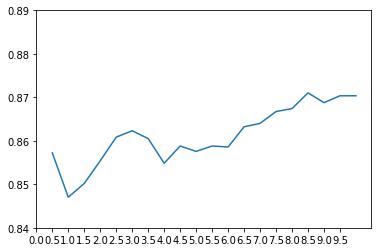

In [11]:
plt.plot(windows, aucs)
plt.xticks(np.arange(0, 10, step=0.5))
plt.ylim((0.84,0.89))
plt.yticks(np.arange(0.84,0.89,step=0.01))
plt.show()

o AUC =  0.8136437371312709
o Optimal Threshold for FI probs =  32.49 %
o AUC =  0.8531207598371777


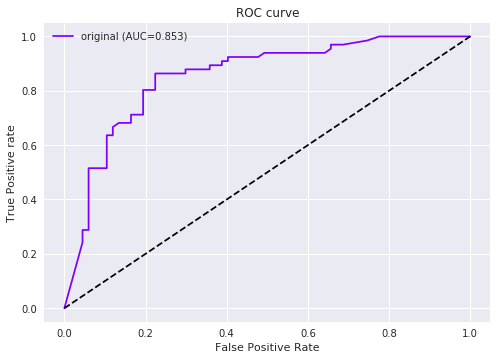

In [44]:
plt.style.use('seaborn')

colors=cm.rainbow(np.linspace(0,1,len(paths)))

stats = []

for path, title, c in zip(paths, titles, colors):
    fpr, tpr, auc_score, metrics = process_preds(path)
    l = title + ' (AUC=' + str(round(auc_score,3)) + ')'
    stat = [title] + metrics
    stats.append(stat)
    plt.plot(fpr, tpr, linestyle='-',color=c, label=l)

#plot random
random_probs = [0 for i in range(1000)]
p_fpr, p_tpr, _ = roc_curve(list(np.arange(1000)), random_probs, pos_label=1)
plt.plot(p_fpr, p_tpr, linestyle='--', color='black')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
#plt.savefig('ROC',dpi=300)
plt.show();

# METRICS

In [25]:
cols = ['Experiment', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'Accuracy']
df = pd.DataFrame(stats)
df.columns = cols
df.set_index('Experiment', inplace=True)
df.to_csv('./stats/03-16-21-hyptuning.csv')
df.head(10)

,Sensitivity,Specificity,PPV,NPV,Accuracy
Experiment,,,,,
resnet,0.769231,0.835821,0.819672,0.788732,80.3%
resnet increase epochs,0.846154,0.701493,0.733333,0.824561,77.27%
inception,0.846154,0.761194,0.774648,0.836066,80.3%
inception increase batch size,0.830769,0.731343,0.750000,0.816667,78.03%
vgg,0.784615,0.776119,0.772727,0.787879,78.03%
vgg increase both,0.784615,0.686567,0.708333,0.766667,73.48%
